In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import shapefile as sf
from pyproj import Proj
from censusgeocode import CensusGeocode

import datetime
import random
import sphviewer

%matplotlib inline

In [2]:
sl_reader = sf.Reader('shapefiles/Street_Light/Street_Light.shp')
sl_record = pd.DataFrame(sl_reader.records())
sl_shapes = sl_reader.shapes()

In [144]:
# Need to convert each Street Light location to latitude and longitude
sl_record['lon'] = None
sl_record['lat'] = None

In [7]:
p1 = Proj("+init=EPSG:2230", preserve_units=True)
print len(sl_record)
for i in range(0,10): 
    lon, lat = p1(sl_shapes[i].points[0][0], sl_shapes[i].points[0][1],inverse=True)
    sl_record.loc[i, 'lon'] = lon 
    sl_record.loc[i, 'lat'] = lat
    if (i % 1000==0):
        print i, i, i 

48455
0 0 0


Associate each street light with its associated block group and census tract.

In [3]:
cg = CensusGeocode()

In [15]:
sl_record.loc[i, 'block'] = None
sl_record.loc[i, 'tract'] = None
sl_record.loc[i, 'geoid'] = None
sl_record.loc[i, 'blockgroup'] = None

In [45]:
start = datetime.datetime.now()

print len(sl_record)

for i in range(46956,len(sl_record)): 
    if ((sl_record.loc[i,'lon']!=0.0) 
        & (np.isnan(sl_record.loc[i,'lon'])==False)) :
        temp1 = cg.coordinates(x=sl_record.loc[i,'lon'], 
                              y=sl_record.loc[i, 'lat'])
        if (len(temp1[0]['2010 Census Blocks'])>0):
            if ('status' not in temp1[0]['2010 Census Blocks'][0].keys()[0]): 
                temp = temp1[0]['2010 Census Blocks'][0]
                if (temp is not None):
                    sl_record.loc[i, 'block'] = temp['BLOCK']
                    sl_record.loc[i, 'tract'] = temp['TRACT']
                    sl_record.loc[i, 'geoid'] = temp['GEOID']
                    sl_record.loc[i, 'blockgroup'] = temp['BLKGRP']

                if (i % 100 == 0): 
                    finish = datetime.datetime.now()
                    print i, finish-start
                    start = datetime.datetime.now()



48455
47000 0:00:51.430666
47100 0:01:44.302094
47200 0:02:20.313068
47300 0:02:40.013126
47400 0:02:49.721932
47500 0:02:26.032445
47600 0:02:18.374865
47700 0:02:01.482173
47800 0:02:16.113438
47900 0:01:50.279062
48000 0:01:21.353079
48100 0:02:07.290142
48200 0:02:04.870696
48300 0:02:11.107390
48400 0:01:12.004652


In [49]:
#sl_record.to_csv('output_files/sl_records_all.csv')

### Above section takes a long time to process. We only want to do it once! The output is saved in and we use it below:

In [6]:
sl_record = pd.read_csv('output_files/sl_records_all.csv')

In [7]:
sl_record['sl_count'] = 0.0

In [8]:
# Number of street lights for each tract and block group
streetlight_count = sl_record[['tract', 'blockgroup', 'sl_count']].groupby(['tract','blockgroup'], as_index=False).agg('count')

In [10]:
reader = sf.Reader('shapefiles/sandiego_city_blockgroups.shp')
bg_info = pd.DataFrame(reader.records())
shapes = reader.shapes()

bg_info.rename(columns={2: 'tract', 3: 'blockgroup', 8: 'land_area'}, inplace=True)
bg_info['tract'] = bg_info['tract'].astype(float)
bg_info['blockgroup'] = bg_info['blockgroup'].astype(float)

### Calculate Street Light density

In [14]:
big_streetlight = pd.merge(bg_info[['tract', 'blockgroup', 'land_area']],streetlight_count[['tract', 'blockgroup', 'sl_count']], on=['tract', 'blockgroup'], how='left')

In [15]:
# Calculate street light density (per meters squared)
big_streetlight['sl_density'] = big_streetlight['sl_count'] / big_streetlight['land_area']

In [10]:
# Remove the tract without block group anomaly
#big_streetlight = big_streetlight.loc[:863].copy()

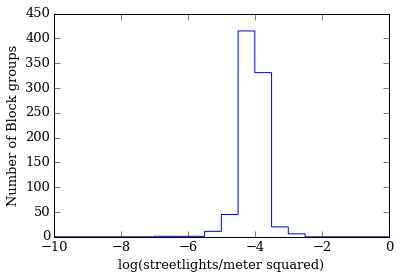

In [83]:
a = plt.hist(np.log10(big_streetlight['sl_density']), bins=20, range=[-10,0], histtype='step')
plt.xlabel('log(streetlights/meter squared)')
plt.ylabel('Number of Block groups')

In [17]:
mc_reader = sf.Reader('shapefiles/Municipal_Boundaries/MUNICIPAL_BOUNDARIES.shp')
mc_records = pd.DataFrame(mc_reader.records())
mc_shapes = mc_reader.shapes()

mc_records_index = np.where(mc_records[1]=='SD')

In [20]:
from matplotlib.path import Path
import colormaps as cmaps



In [50]:
yak = zip(barf[0], barf[1])
vom = zip(cs[1], cs[2])

In [51]:

path = Path(yak)
grid = path.contains_points(vom)

In [61]:
alpha_values = cs[0]
alpha_values[np.where(alpha_values!=0)] = 1.0
alpha_values[np.where(alpha_values==0)]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [72]:
palette = cmaps.magma
palette.set_over('w', 1.0)
palette.set_under('k', 0.0)


palette2 = plt.cm.cubehelix
palette2.set_over('w', 1.0)
palette2.set_under('w', 0.0)


In [77]:
font={'family': 'serif', 
       'weight': 'normal', 
        'size' : 13, 
        'style' : 'oblique' }
plt.rc('font', **font)
plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=6, pad=4)
plt.rc('xtick.minor', size=3, pad=4)
plt.rc('ytick.major', size=6, pad=4)
plt.rc('ytick.minor', size=3, pad=4)

In [35]:
from astropy.convolution.kernels import Gaussian2DKernel
from astropy.convolution import convolve

In [ ]:
p1 = Proj("+init=EPSG:2230", preserve_units=True)

fig,ax = plt.subplots(1,1, figsize=(10,10))

#cs = plt.hist2d(sl_record['lon'], sl_record['lat'], bins=(400,400), cmap=palette, vmax=10, 
#          range=([-117.3,-116.9], [32.5, 33.3]), alpha=1.0, vmin=0.05, zorder=2)
#cs = plt.hexbin(sl_record['lon'], sl_record['lat'], gridsize=400, cmap=palette2, vmax=10, 
#          extent=[-117.3,-116.9,32.5, 33.3], vmin=0.05, zorder=2)
heatmap, xedges, yedges = np.histogram2d(sl_record['lon'], sl_record['lat'], bins=400)

plt.imshow(convolve(heatmap.transpose(), Gaussian2DKernel(stddev=1.0)), interpolation='none', 
          cmap=palette, vmin=0.05, origin='lower',extent=(xedges.min(),xedges.max(),
                                                          yedges.min(),yedges.max()),
           aspect='auto', vmax=10, zorder=2)




plt.colorbar(fraction=0.046, pad=-0.1, shrink=1.0).set_label(label='Number of Streetlights',
                                                                       size=15)

patches = []
for i in range(0,len(bg_info)): 
    barf = pd.DataFrame(shapes[i].points)
    poly = plt.Polygon(barf[[0,1]], fc='k', ec='k', alpha=1.0, lw=1.0, zorder=1)
    patches.append(poly)
    plt.gca().add_patch(poly)

    
patches = []
for i in range(32,33): 
    print i
    temp = pd.DataFrame(mc_shapes[i].points)
    lon, lat = p1(np.array(temp.loc[0:33632, 0]), np.array(temp.loc[0:33632, 1]), inverse=True)
    poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='b', alpha=1.0, lw=3.0, zorder=3)
    patches.append(poly)
    #plt.gca().add_patch(poly)


plt.axis('scaled')
plt.minorticks_on()


plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.ylim(32.533541,33.116178)
plt.xlim(-117.29,-116.85)

# Set the X tick labels so they're useful! 
x_vals = [-117.2, -117.1, -117.0, -116.9]
labels = ['-117.2', '-117.1', '-117.0', '-116.9']
ax.set_xticks(x_vals)
ax.set_xticklabels(labels)


#plt.axis("off")
#plt.show()

#plt.savefig('output_figures/streetlights_map_smoothed.png', bbox_inches='tight')
#mpld3.display()



In [109]:
#import seaborn as sns

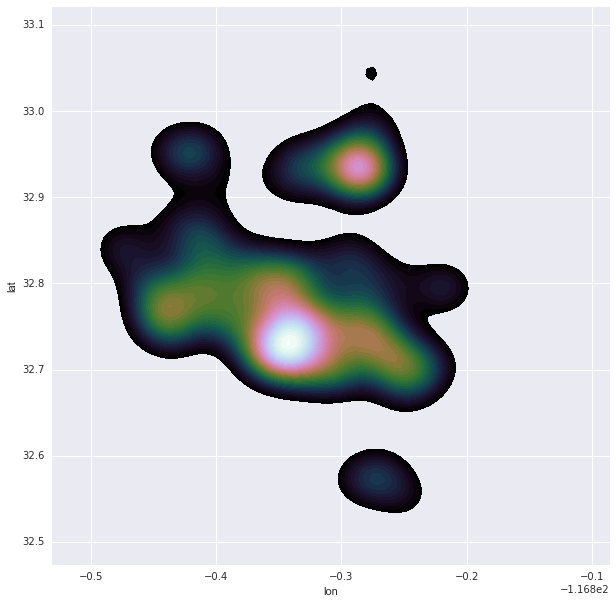

In [119]:
f, ax = plt.subplots(figsize=(10, 10))
sns.kdeplot(sl_record.loc[0:1000,'lon'], sl_record.loc[0:1000,'lat'], 
            cmap='cubehelix', n_levels=50, shade=True, shade_lowest=False, zorder=2, vmin=5)



32


(-117.31, -116.84999999999999, 32.533541, 33.116177999999998)

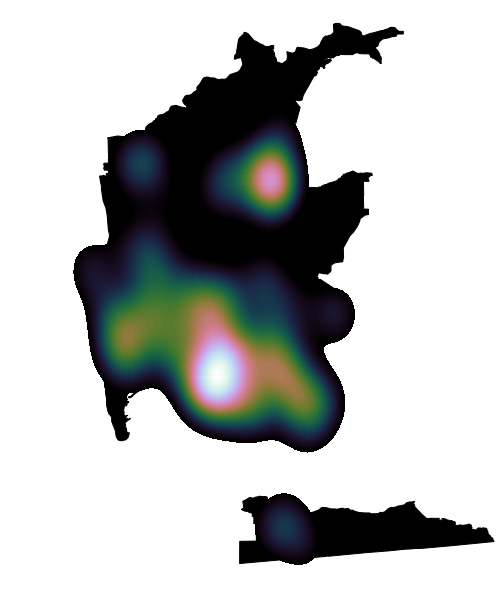

In [121]:
f, ax = plt.subplots(figsize=(10, 10))
sns.kdeplot(sl_record.loc[0:1000,'lon'], sl_record.loc[0:1000,'lat'], 
            cmap='cubehelix', n_levels=100, shade=True, shade_lowest=False, zorder=2, 
            vmin=5)

patches = []
for i in range(0,len(bg_info2)): 
    barf = pd.DataFrame(shapes2[i].points)
    poly = plt.Polygon(barf[[0,1]], fc='k', ec='k', alpha=1.0, lw=1.0, zorder=1)
    patches.append(poly)
    plt.gca().add_patch(poly)

    
patches = []
for i in range(32,33): 
    print i
    temp = pd.DataFrame(mc_shapes[i].points)
    lon, lat = p1(np.array(temp.loc[0:33632, 0]), np.array(temp.loc[0:33632, 1]), inverse=True)
    poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='b', alpha=1.0, lw=3.0, zorder=3)
    patches.append(poly)
    #plt.gca().add_patch(poly)


plt.axis('scaled')
plt.minorticks_on()


plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.ylim(32.533541,33.116178)
#plt.ylim(32.70,32.72)

plt.xlim(-117.31,-116.85)
#plt.xlim(-117.2,-117.1)

plt.axis("off")
#plt.show()

#plt.savefig('output_figures/streetlights_map.png', bbox_inches='tight')
#mpld3.display()




### We want to estimate the typical distance from a street light for a random location in each blockgroup.

In [53]:
sdcounty['sl_minidist_mean'] = None
sdcounty['sl_minidist_std'] = None
sdcounty['sl_minidist_median'] = None

In [58]:
# Select 250 random points in each block group and see their distance from a streetlight. 
print len(sdcounty_index)

for i in range(1576,len(sdcounty_index)): 
    #if (len(np.where(sd_city_proper['tract'] == sdcounty.loc[sdcounty_index[i], 'tract'])[0])>0): 

    mindist = []
    for p in range(0,250): 
        # use bounding box to select random points within the block group
        maxx, maxy, minx, miny = shapes[sdcounty_index[i]].bbox
        random_lat = miny + (random.random() * (maxy-miny))
        random_lon = minx + (random.random() * (maxx-minx))

        # compare the random point to the street light locations
        R = 6371 * 3280.84 # feet

        dLat = np.radians(np.array(np.array(sl_record['lat']) - random_lat).astype(float))
        dLon = np.radians(np.array(np.array(sl_record['lon']) - random_lon).astype(float))
        lat_source = np.radians(random_lat)
        lat_comp = np.radians(np.array(sl_record['lat']).astype(float))

        a = np.sin(dLat/2.0) * np.sin(dLat/2.0) + np.sin(dLon/2.0) * np.sin(dLon/2.0) * np.cos(lat_source) * np.cos(lat_comp) 
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        d = R * c
        mindist.append(float(d[np.argmin(d)]))
            
    sdcounty.loc[sdcounty_index[i], 'sl_minidist_mean'] = np.mean(mindist)
    sdcounty.loc[sdcounty_index[i], 'sl_minidist_std'] = np.std(mindist)
    sdcounty.loc[sdcounty_index[i], 'sl_minidist_median'] = np.median(mindist)

    if (i % 100 == 0): 
        print i, i, i
    if (i % 250 == 0): 
        sdcounty[['tract', 'blockgroup', 'sl_minidist_mean', 'sl_minidist_std', 
                  'sl_minidist_median']].to_csv('output_files/sdcounty_sldistance.csv', index=False)


1794
1600 1600 1600
1700 1700 1700


In [149]:
#sdcounty[['tract', 'blockgroup', 'sl_minidist_mean', 'sl_minidist_std', 
#          'sl_minidist_median']].to_csv('output_files/sdcounty_sldistance.csv', index=False)

In [151]:
sdcounty = pd.read_csv('output_files/sdcounty_sldistance.csv')

Compare with the mean street light distance for graffiti events

In [147]:
barf = pd.read_csv('output_files/total_reports_demo_0917.csv')

In [75]:
barf.columns.values

array(['Unnamed: 0', 'tract', 'blockgroup', 'count', 'graffiti_count',
       'dump_count', 'lighting_count', 'gsl_meandist', 'gsl_stddist',
       'gsl_mediandist', 'dsl_meandist', 'dsl_stddist', 'dsl_mediandist',
       'sl_count', 'landarea', 'cent_lat', 'cent_lon', 'sl_density',
       'total_pop', 'rep_per_cap', 'graffiti_per', 'dump_per',
       'lighting_per', 'tract_in_city'], dtype=object)

In [152]:
puker = pd.merge(barf[['tract', 'blockgroup', 'gsl_meandist', 'gsl_stddist', 
                       'gsl_mediandist', 'dsl_meandist', 'dsl_stddist', 
                       'dsl_mediandist','tract_in_city']], 
                 sdcounty[['tract', 'blockgroup', 'sl_minidist_mean', 'sl_minidist_std', 
                          'sl_minidist_median']], 
                on=['tract', 'blockgroup'], how='left')

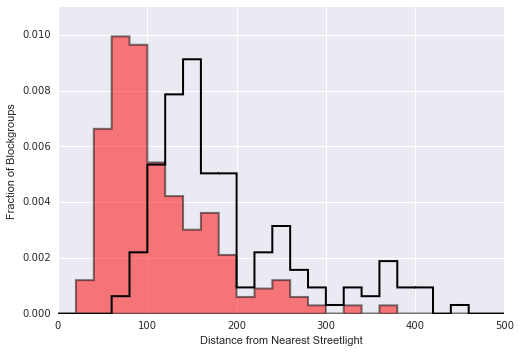

In [155]:
a = plt.hist(puker.loc[np.where(barf['graffiti_per']>0.25)[0], 'gsl_meandist'], bins=25, 
             range=[0.1, 500], histtype='stepfilled', alpha=0.5, color='r', 
             lw=2, normed=True)
b = plt.hist(puker.loc[np.where(barf['graffiti_per']>0.25)[0], 'sl_minidist_mean'], bins=25, range=[0.1, 500], histtype='step', color='k', 
             lw=2, normed=True)
plt.xlabel('Distance from Nearest Streetlight')
plt.ylabel('Fraction of Blockgroups')
plt.ylim(0,0.011)
plt.minorticks_on()

#plt.savefig('output_figures/sl_mindist_gper25.png', bbox_inches='tight')

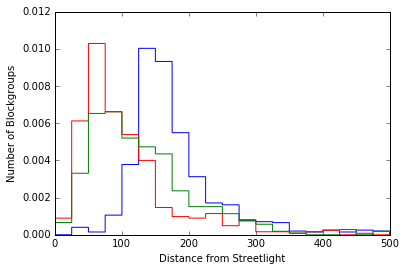

In [77]:
plt.hist(puker.loc[np.where(puker['tract_in_city']==1.0)[0], 'sl_minidist_median'], 
             bins=20, range=[0,500], histtype='step', color='b', normed=True)
plt.hist(puker.loc[np.where(puker['tract_in_city']==1.0)[0],'gsl_mediandist'], 
             bins=20, range=[0,500], histtype='step', color='r', normed=True)
plt.hist(puker.loc[np.where(puker['tract_in_city']==1.0)[0],'dsl_mediandist'], 
             bins=20, range=[0,500], histtype='step', color='g', normed=True)

plt.xlabel('Distance from Streetlight')
plt.ylabel('Number of Blockgroups')

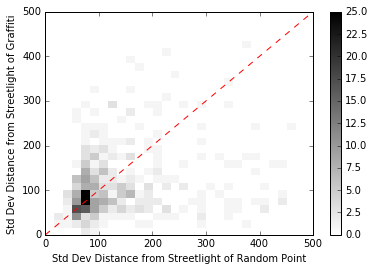

In [80]:
#plt.plot(puker['sl_minidist'], puker['gsl_meandist'], 'k.')
plt.hist2d(puker['sl_minidist_std'].astype(float), puker['gsl_stddist'].astype(float), 
           range=([0,500],[0,500]), bins=(30,30), cmap='binary')
plt.colorbar()
plt.xlim(0,500)
plt.ylim(0,500)
plt.plot([0,500],[0,500], 'r--')
plt.xlabel('Std Dev Distance from Streetlight of Random Point')
plt.ylabel('Std Dev Distance from Streetlight of Graffiti')